# ECG Heartbeat Classification EDA
## Background information
- **Electrocardiogram(ECG)** measures the hearts electrical activity of the heart.
- According to (Kachuee et al., 2018), Manual ECG review are difficult when detecting and categorizing different waveform and morphologies

### How does a heartbeat look like in a ECG signal?

To answer that, we must understand the different parts of the wave:
* __P-wave__: Starts the heartbeat, the atria(upper chamber) is contracting
* __PR interval__: Repersents the time it takes for the electical move between the __atria and the ventricle__. This time repersents the heart __natural pacemaker__.
* __QRS Complex__: Basically the beat, the sharp spike, this is when the __ventricle__ contracts and pushes blood through the body
* __ST segment__: The heart is basically relaxing here before the next heartbeat
* __T wave__: The final wave -- repolarization of the ventricles, preparing for the next heart beat

The guess is that the machine learning model should be able to learn these shapes to predict the difference between a __Normal__ vs __Abnormal__ ECG signal.

### Visual Representation Of ECG Wave

**Figure 1**

*ECG Heart Beat Visualization*

![ECG Heartbeat](./images/heatbeat.png)

*Note.* This visualization shows how the waveform of a heart beat might generally look like.
### Objective -- what are we trying to look for?
- We want to use a machine learning model, where in this notebook, we will be exploring __classical model__(i.e., Decision Tree, KMeans, etc.).

### Imports

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycatch22
import seaborn as sns
from imblearn.over_sampling import SMOTE

# Scipy related imports
from scipy.fft import rfft, rfftfreq
from scipy.signal import find_peaks
from scipy.stats import kurtosis, skew, zscore

# Sklearn related imports
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree

### Constants

In [2]:
SAMPLE_RATE = 125
CLASSIFICATION_COL = 187
RANDOM_SEED = 42

### (Exploratory Data Analysis)EDA
- Going to be using the ptbdb datasets which just contains __only two classification__, and they are __Normal(0)__ and __Abnormal(1)__.
- The __last column__ of the datasets contains the classification.

#### Goal of this EDA:
The goal of this __EDA__ is to explore the __ptbdb datasets__ such that we can figure out the integrity of the data(i.e., Is there missing values? do the values make sense?, etc.), and the characteristics between __abnormal__ vs __normal__, such that we can differentiate them. This Exploration is essential in __making informed decision__ about the data __preprocessing__ and __what machine learning model to select__.

### Is there anything wrong with the data?
This is simply a __sanity check__ to make sure there is no missing values or checking to see if the types of data make sense to a computer(i.e., Encoding strings as number(1=Abnormal)), and if the typing makes sense(i.e., converting a date that is a str to datetime, float64->float32 -- we dont need that high of a precision).

In [3]:
# Setting the paths of where I downloaded the datasets.
normal_train_path = "./.data/ptbdb_normal.csv"
abnormal_train_path = "./.data/ptbdb_abnormal.csv"
normal_df = pd.read_csv(normal_train_path, header=None)
abnormal_df = pd.read_csv(abnormal_train_path, header=None)
df = pd.concat([normal_df, abnormal_df], axis=0)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
classes_freq = df.iloc[:, -1].value_counts()
sorted_classes_freq = classes_freq.sort_index()
sorted_classes_freq

187
0.0     4046
1.0    10506
Name: count, dtype: int64

In [5]:
assert df.isna().sum().sum() == 0
print("No missing values in data!")

No missing values in data!


In [6]:
df.dtypes

0      float64
1      float64
2      float64
3      float64
4      float64
        ...   
183    float64
184    float64
185    float64
186    float64
187    float64
Length: 188, dtype: object

In [7]:
df = df.astype("float32")
df.dtypes

0      float32
1      float32
2      float32
3      float32
4      float32
        ...   
183    float32
184    float32
185    float32
186    float32
187    float32
Length: 188, dtype: object

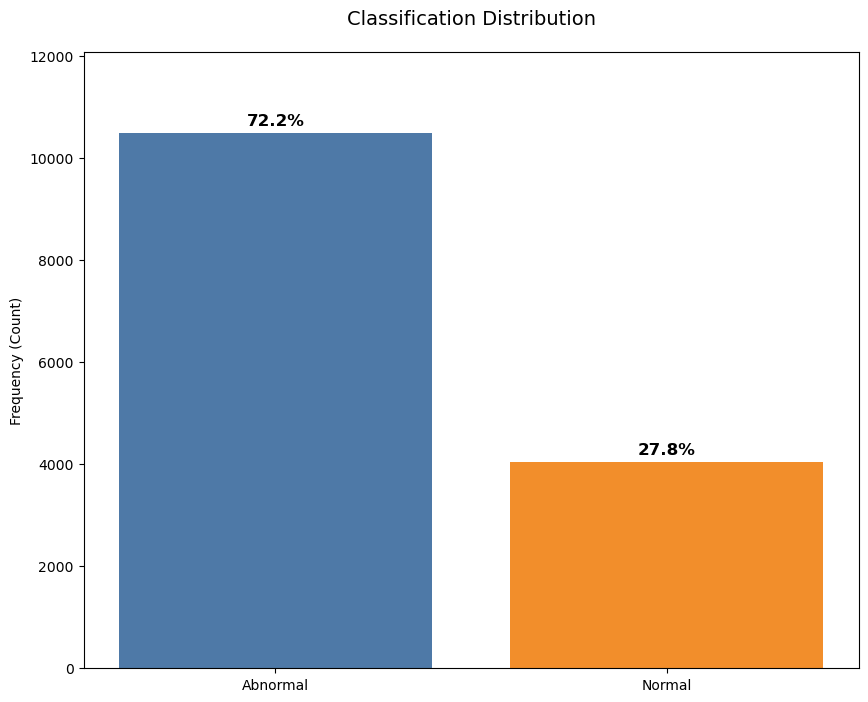

In [8]:
# Getting the counts and the way to label the plot with percentage
counts = df[CLASSIFICATION_COL].value_counts()
percentage = counts / len(df) * 100

fig, ax = plt.subplots(figsize=(10, 8))
bars = ax.bar(["Abnormal", "Normal"], counts, color=["#4e79a7", "#f28e2b"])
labels = [f"{pct:.1f}%" for pct in percentage]

# Adding the labels
ax.bar_label(bars, labels=labels, padding=3, fontsize=12, fontweight="bold")
ax.set_title("Classification Distribution", fontsize=14, pad=20)
ax.set_ylabel("Frequency (Count)")
ax.set_ylim(0, max(counts) * 1.15)  # Add headroom for labels
plt.show()

### Ptbdb datasets Summary
* __Total Samples__: 4045(Normal Samples) + 10505(Abnormal Samples) = 14550 Samples/Rows
* __Classes__: Abnormal(1) and Normal(0)


* No need to check for duplicate values for columns because signals is periodic wave, therefore, their should be duplicates.
* Changed data types for all values to float32.

_Note: __Imbalance__ between __abnormal__ and __normal__ data._

Before we statically find outliers or see if the groups are statistically different. Let us first see it __visually__ by __selecting two random ECG signal from each datasets(i.e., Normal and Abnormal)__. We choose at random, two from the same datasets to see if we can see variation visually. Then we are getting for each datasets to see if they look different from each other. The code below does the following.

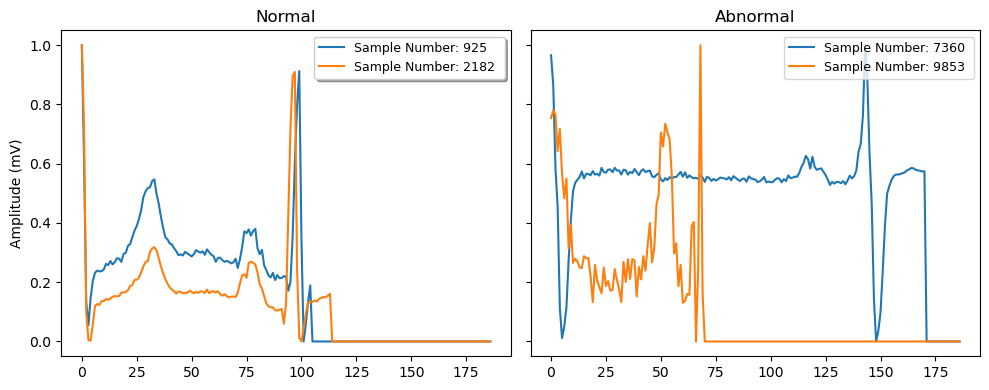

In [9]:
def visualize_differences_with_line_graph(
    normal: pd.DataFrame, abnormal: pd.DataFrame
) -> None:
    """Visualize differences within group and between groups.

    The signals are chosen at random.

    Args:
      normal : pd.DataFrame
        Dataframe that contains the normal ECG signal of a heart.
      abnormal : pd.DataFrame
        Dataframe that contains the abnormal ECG signal of a heart.

    Returns:
     Two plots, one for abnormal and the other for normal. Each
     containing two signals.
    """
    two_rand_numbers = 2
    # Tell us which signal we are choosing
    first_within_signal = 0
    second_within_signal = 1
    first_between_signal = 0
    second_betwee_signal = 1

    # Randomly chooses a signal
    choose_rand_normal_signal = np.random.randint(0, len(normal), two_rand_numbers)
    choose_rand_abnormal_signal = np.random.randint(0, len(abnormal), two_rand_numbers)
    # Plotting
    first_plot = 1
    second_plot = 2
    fig, axes = plt.subplots(first_plot, second_plot, sharey=True, figsize=(10, 4))

    # Normal signal plotting
    axes[first_between_signal].plot(
        normal.iloc[choose_rand_normal_signal[first_within_signal], :-1].values,
        label=f"Sample Number: {choose_rand_normal_signal[first_within_signal]} ",
    )
    # Second normal signal
    axes[first_between_signal].plot(
        normal.iloc[choose_rand_normal_signal[second_within_signal], :-1].values,
        label=f"Sample Number: {choose_rand_normal_signal[second_within_signal]} ",
    )
    axes[first_between_signal].legend(
        shadow=True, frameon=True, facecolor="inherit", loc=1, fontsize=9
    )
    axes[first_between_signal].set_title("Normal")

    # Only need to set one y-axis title because they both have the same titles
    axes[first_between_signal].set_ylabel("Amplitude (mV)")

    # Abnormal Signal plotting
    axes[second_betwee_signal].plot(
        abnormal.iloc[choose_rand_abnormal_signal[first_within_signal], :-1].values,
        label=f"Sample Number: {choose_rand_abnormal_signal[first_within_signal]} ",
    )
    # Second abnormal signal
    axes[second_betwee_signal].plot(
        abnormal.iloc[choose_rand_abnormal_signal[second_within_signal], :-1].values,
        label=f"Sample Number: {choose_rand_abnormal_signal[second_within_signal]} ",
    )
    axes[second_betwee_signal].legend(
        frameon=True, facecolor="inherit", loc=1, fontsize=9
    )
    axes[second_betwee_signal].set_title("Abnormal")
    plt.tight_layout()
    plt.show()


visualize_differences_with_line_graph(abnormal=abnormal_df, normal=normal_df)

### Conclusion from Visualization
1. __Abnormal Vs Normal Signal__:
    * Generally seems to have more amplitude.
    * Normal seems to have 2 peaks, where as Abnormal might only have 1 noticeable one.

### Outlier Detection Using Z-Scores
- Z-score are generally used as a statistical approach to __identify extreme or not of the "normal"__ within a datasets. Z-scores determine how far a given sample deviates from its mean, within its distribution(i.e., The scatter of points). This should help us detect signals that are unusual.
- Now, since there is an __imbalance__ and we know that these two signals should differ, we will do a __focused z-score within each classification(i.e., Abnormal or Normal, and not both)__.
- Additionally, we know that the signals __QRS Wave__ appears at different time steps so we are looking for a __signal thats Z-score is greater than 9__.

In [10]:
# Removing the classifications from the abnormal and normal dfs.
# Where_to_apply_z_score=0 is every time step, and Where_to_apply_z_score=1 is every signal
Where_to_apply_z_score = 1
normal_X = normal_df.iloc[:, :-1].values
normal_y = normal_df[CLASSIFICATION_COL]
abnormal_X = abnormal_df.iloc[:, :-1].values
abnormal_y = abnormal_df[CLASSIFICATION_COL]
# The threshold is used to see how many times is a value
# greater or less than the average. The threshold is 9
# because the QRS wave will make it seem that every
# signal is an outlier because the QRS wave makes
# everything an outlier.
threshold = 9
# axis = 1 means that we are doing it cols by cols
z_scores_normal = np.abs(zscore(normal_X, axis=Where_to_apply_z_score))

outlier_normal_rows = np.where(np.max(z_scores_normal, axis=1) > threshold)[0]
if len(outlier_normal_rows) > 0:
    print(
        f"Normal Dataset: {len(outlier_normal_rows)} potential outlier signals (Z-score > {threshold})."
    )
else:
    print("No outliers for Normal!")
# Abnormal
z_scores_abnormal = np.abs(zscore(abnormal_X, axis=Where_to_apply_z_score))
# This finds the rows where the z-score is
outlier_abnormal_rows = np.where(np.max(z_scores_abnormal, axis=1) > threshold)[0]
if len(outlier_abnormal_rows) > 0:
    print(
        f"Abnormal Dataset: {len(outlier_abnormal_rows)} potential outlier signals (Z-score > {threshold})."
    )
else:
    print("No outliers for Abnormal!")

Normal Dataset: 5 potential outlier signals (Z-score > 9).
Abnormal Dataset: 7 potential outlier signals (Z-score > 9).


### Conclusion from Outlier Detection Using Z-scores
- There seems to be no outliers when you compare each time step within its own classification.
- However, within a signal, there exist 5 potential outlier signals for the normal datasets and 7 potential outlier signals for the abnormal datasets.

### Statistical and Physical Properties of ECG Signals
- we want to extract all the feature from the __abnormal__ and __normal__ datasets.
- The feature we want to extract fall into two categories __physical__ and __statistical__. The __physical__ categories are found in the __time domain__ and the __statistical__ are found in the __frequency domain__.
The following features are sorted into the respective categories:

1. __Time domain - Statistical__
   * __Mean,Median,Standard Deviation, Skewness, Kurtosis__: Allows us to understand how the amplitude is different abnormal vs normal. Additionally, how normal is similar to normal, and same with abnormal.
   * __Energy__: The sum of squared amplitudes.
   * __Max_value/R_Peak__: The maximum value of the signal. In other words, the __R Peak__ in the __QRS Wave__. 
   * __Minimum Value__: The minimum amplitude within a signal.
   * __Mean of Slope(First Derivatives)__: Captures the detrends. Checking if the rate of change and also if its generally increasing or decreasing.
   * __Zero-Crossing__: Since we know that its a real signal, this must mean its a sinusoidal waveform of some sort. therefore, it oscillates, and crosses the x-axis.
2. __Frequency Domain - Physical__ 
   * __Dominate Frequencies__: Going to take the largest frequency
   * __Spectral Centroid__: The idea is that if the freq are high, then the spectral centroid is a higher number, and if freq are low, its the opposite case.

- [Feature extraction](https://matteogambera.medium.com/how-to-extract-features-from-signals-15e7db225c15)

### Mean Visual Analysis

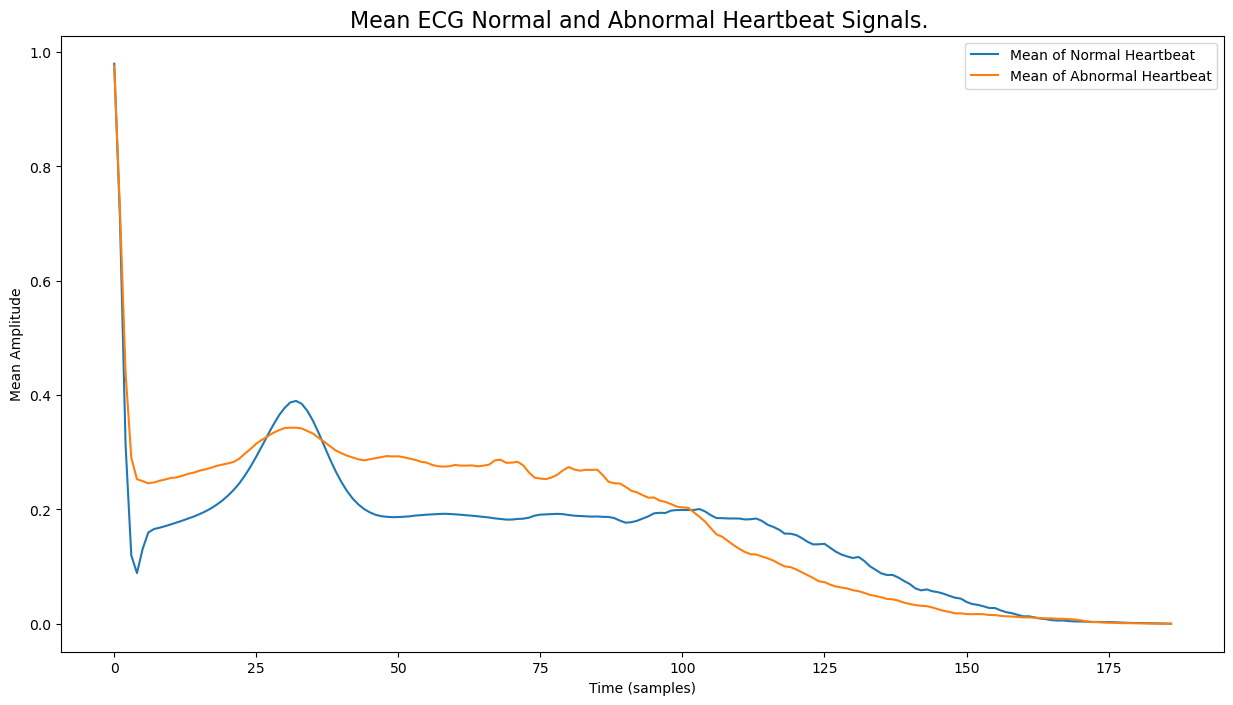

(187,)

In [11]:
plt.figure(figsize=(15, 8))
# We want the mean of each time step(i.e., column)
# so we do axis=0.
normal_signal_avg = normal_X.mean(axis=0)
abnormal_signal_avg = abnormal_X.mean(axis=0)
plt.plot(normal_signal_avg, label=f"Mean of Normal Heartbeat")
plt.plot(abnormal_signal_avg, label=f"Mean of Abnormal Heartbeat")
plt.title("Mean ECG Normal and Abnormal Heartbeat Signals. ", fontsize=16)
plt.xlabel("Time (samples)")
plt.ylabel("Mean Amplitude")
plt.legend()
plt.show()
normal_signal_avg.shape

### Conclusion from Mean visual analysis
- Generally, there seems to be a __difference__ between the abnormal and the normal because it can be seen that the __Abnormal waveform__ overtime seems to be more positive in its mV amplitudes.
- Additionally, It seem that there is a __faster decay__ in the amplitude of __abnormal__.
- There also seems to be __some sort of peak__ that is more apparent around time step 25 for the __normal waveform__.

### Standard Deviation Visual Analysis
- Essentially, we are looking to see if the signals deviate from their baseline. If they deviate a lot, within the signal, that means it fluctuates and is not predictable.

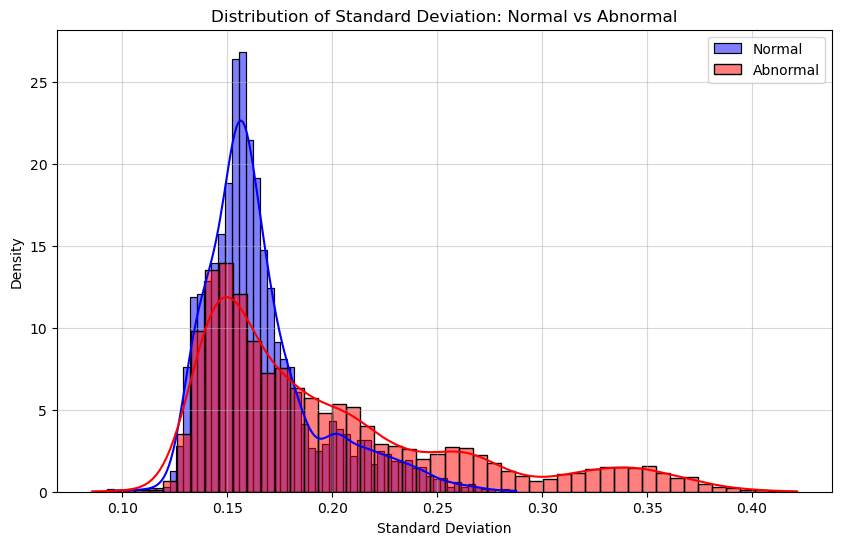

In [12]:
normal_signal_avg = normal_X.std(axis=1)
abnormal_signal_avg = abnormal_X.std(axis=1)
plt.figure(figsize=(10, 6))
sns.histplot(
    normal_signal_avg, color="blue", kde=True, label="Normal", stat="density", alpha=0.5
)
sns.histplot(
    abnormal_signal_avg,
    color="red",
    kde=True,
    label="Abnormal",
    stat="density",
    alpha=0.5,
)

plt.title("Distribution of Standard Deviation: Normal vs Abnormal")
plt.xlabel("Standard Deviation")
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

### Conclusion from Standard Deviation visual analysis
- It can be said that the __abnormal__ waveform seems to deviate more but still follows a rhythmic beat, hence why the peaks are the same. However, its not as rhythmic as the __normal__ instead the distribution basically claims the __abnormal__ is more chaotic, which is what we would expect. 

### Skewness of Visual Analysis
- Skewness can be interpreted relative to 0, as in:
    1. Skewness > 0: This __positive skewness__ means that there is a __spike__ in the data but the values are relatively high.
    2. Skewness < 1: This __negative skewness__ means that the values could be low or high but fluctuate at the same values, and additionally, it could mean that there is a negative inflection.

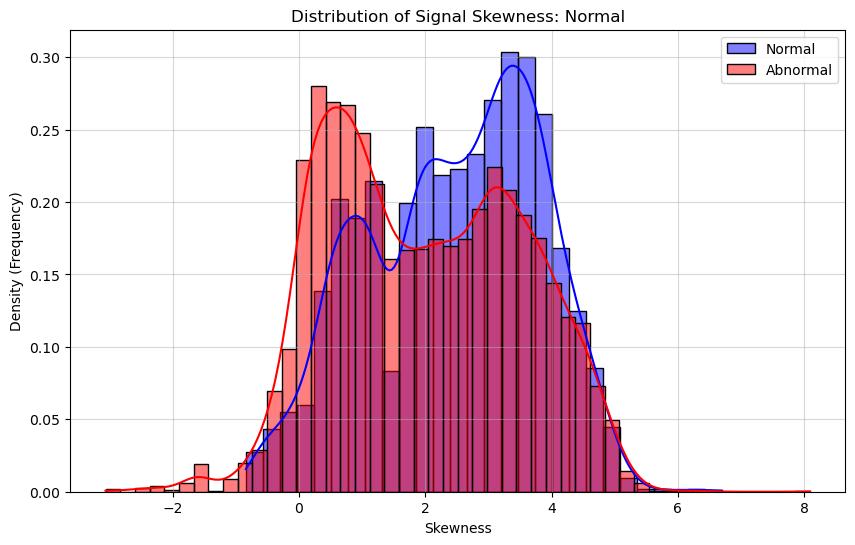

In [13]:
skewness_normal = skew(normal_X, axis=1)
skewness_abnormal = skew(abnormal_X, axis=1)
plt.figure(figsize=(10, 6))
sns.histplot(
    skewness_normal, color="blue", kde=True, label="Normal", stat="density", alpha=0.5
)
sns.histplot(
    skewness_abnormal,
    color="Red",
    kde=True,
    label="Abnormal",
    stat="density",
    alpha=0.5,
)
plt.title("Distribution of Signal Skewness: Normal")
plt.xlabel("Skewness")
plt.ylabel("Density (Frequency)")
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

### Conclusion from Skewness of Visual Analysis
- Firstly, Skewness shows a slight difference in where the peaks with the abnormal and normal classification.
- It also seem that __abnormal__ might have more of a __negative inflection__(i.e., values goes downwards more).
- It seems that the __normal__ waveform might have more of a positive peak, hence its more __positive skewness__.

### kurtosis of Visual Analysis
- Basically tells you if the data lies more near the mean or towards the outliers. Sharper peak would infer that its closer to the mean while a more rounded peak would infer the data has outliers.

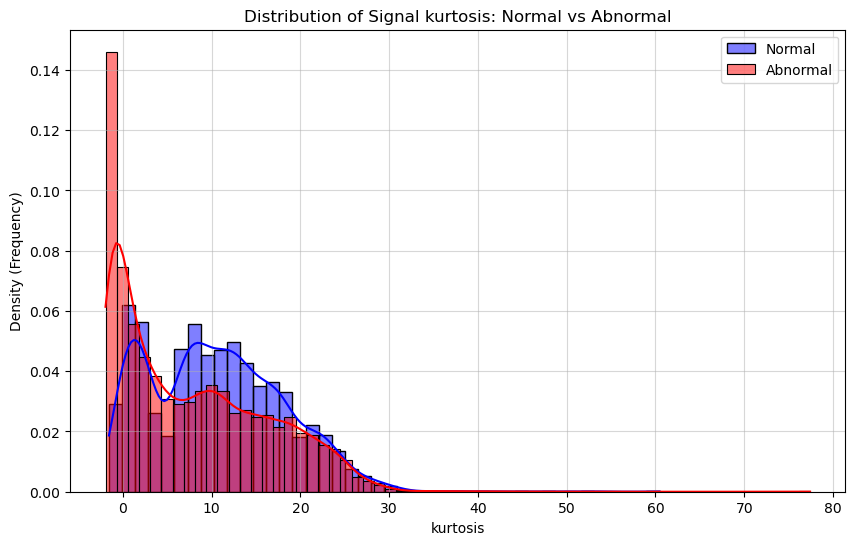

In [14]:
kurtosis_normal = kurtosis(normal_X, axis=1)
kurtosis_abnormal = kurtosis(abnormal_X, axis=1)
plt.figure(figsize=(10, 6))
sns.histplot(
    kurtosis_normal, color="blue", kde=True, label="Normal", stat="density", alpha=0.5
)
sns.histplot(
    kurtosis_abnormal,
    color="Red",
    kde=True,
    label="Abnormal",
    stat="density",
    alpha=0.5,
)
plt.title("Distribution of Signal kurtosis: Normal vs Abnormal")
plt.xlabel("kurtosis")
plt.ylabel("Density (Frequency)")
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

### Conclusion from kurtosis of Visual Analysis
- The distribution seems to be the same among both classifications, however, the __Normal__ seems to have a higher kurtosis(~10 to 20), meaning the signal might have a high level of outlier(i.e., our sharp __QRS WAVE__ which is expected from a normal healthy heart.)
- The __abnormal__ has a kurtosis of 0, meaning it has a more of a __normal distribution__, meaning that it does not have spikes, instead it fluctuates at a certain level. This actually can be seen in the random plotting of abnormal vs normal and also the mean throughout the time step.

### Median of Visual Analysis
- It will tell us how the values are generally distributed.

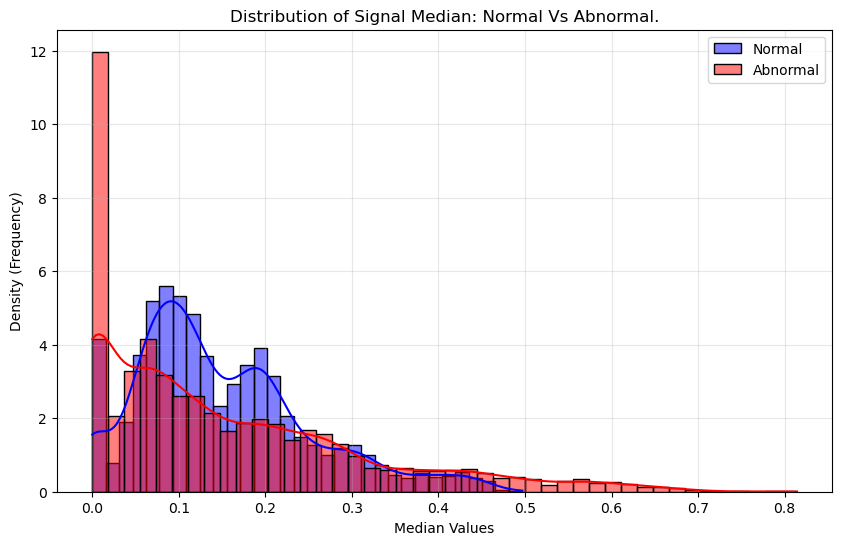

In [15]:
normal_median = np.median(normal_X, axis=1)
abnormal_median = np.median(abnormal_X, axis=1)
plt.figure(figsize=(10, 6))
sns.histplot(
    normal_median, color="blue", kde=True, label="Normal", stat="density", alpha=0.5
)
sns.histplot(
    abnormal_median,
    color="Red",
    kde=True,
    label="Abnormal",
    stat="density",
    alpha=0.5,
)
plt.title("Distribution of Signal Median: Normal Vs Abnormal.")
plt.xlabel("Median Values")
plt.ylabel("Density (Frequency)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Median of Visual Analysis
- seems like the median distribution of the __abnormal__ waveform is more varied. 

### Frequency Analysis
_Note: The starting point of the clip of data is probably affecting the freq present_

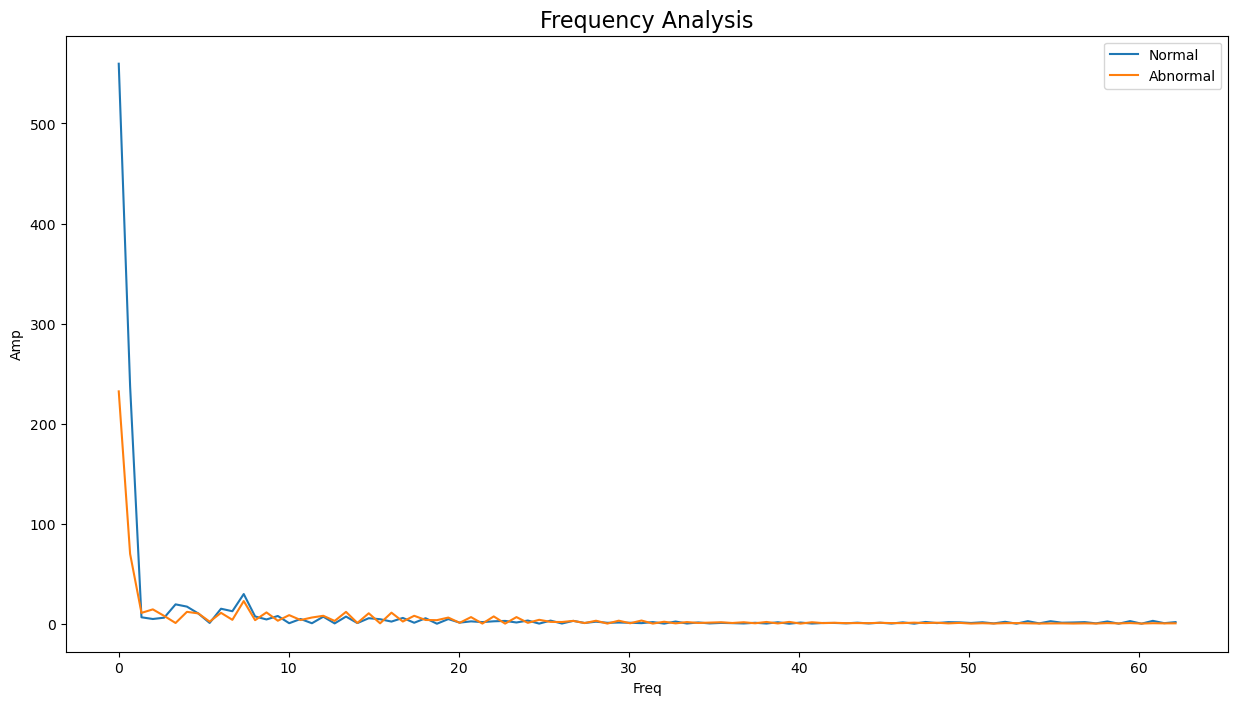

In [16]:
T = 1 / SAMPLE_RATE
N = len(normal_X[0])

# FFT
yf_normal = rfft(normal_X, axis=-1)
yf_abnormal = rfft(abnormal_X, axis=-1)
xf = rfftfreq(N, T)

band_mask = (xf >= 0) & (xf <= 10)
choose_rand_signal = np.random.randint(0, len(yf_normal))
plt.figure(figsize=(15, 8))
choose_rand_signal = np.random.randint(0, len(yf_normal))
plt.plot(xf, np.abs(yf_normal[choose_rand_signal] ** 2), label=f"Normal")
plt.plot(xf, np.abs(yf_abnormal[choose_rand_signal] ** 2), label=f"Abnormal")
plt.title("Frequency Analysis", fontsize=16)
plt.xlabel("Freq")
plt.ylabel("Amp")
plt.legend()
plt.show()

### Frequency Analysis Conclusion
- Seems like __abnormal__ freq band from 0 to 10 have a higher amplitude. This might be useful to differentiate normal from abnormal.

Now that we have a general understanding that there is a __difference__ between the __normal__ and __abnormal__ waveform, we can extract these physical and statistical features to see if a machine learning model can differentiate these signals as well.

__Correlation Analysis__ to see which features correlate will help us find features that might influences each other the most.

In [17]:
def calculate_band_power(
    signals: np.ndarray, low_freq: int, high_freq: int, fs: int = SAMPLE_RATE
) -> np.ndarray:
    """Converts multiple signals into their frequency domain. Then
    calculates the sum of FFT magnitudes within a specified frequency band.

    This function isolates the frequencies between `low_freq` (inclusive)
    and `high_freq` (inclusive) and sums the corresponding values from the
    FFT array.

    Args:
      signals : np.ndarray
        2D array of raw signals.
      fs : int
        Sample rate.
      low_freq : int
        The lower bound of the frequency band (inclusive).
      high_freq : int
        The upper bound of the frequency band (inclusive).
    Returns:
        The sum of values within the band.

    """
    period = 1 / fs
    num_of_samples = signals.shape[-1]
    freqs = rfftfreq(num_of_samples, period)
    # FFT to get the magnitudes of the signals
    mag = np.abs(rfft(signals, axis=-1))
    # low <= f < high
    band_mask = (freqs >= low_freq) & (freqs < high_freq)

    mag_band = mag[..., band_mask]
    return np.sum(mag_band, axis=-1)

In [18]:
def spectral_centroid(signals: np.ndarray, fs: int = SAMPLE_RATE) -> np.ndarray:
    """Takes raw signals and tries to find the spectral centroid.
    The spectral centroid indicates if the frequencies are high,
    if high, then the spectral centroid is high for that signal.

    Args:
      signals : np.ndarray
        2D array of raw signals.
      fs : int
        Sample rate.

    Returns:
      1D array corrosponding to each row of the original array of signals.
      Each index has the spectral centroid value for that signal.

    """
    # NOTE(s1perera) Aug 19, 2025: possible use welch instead because we reduce the noise of the signal
    period = 1 / fs
    num_of_samples = signals.shape[-1]
    xf = rfftfreq(num_of_samples, period)
    # FFT to get the magnitudes of the signals
    mag = np.abs(rfft(signals, axis=-1))
    # https://stackoverflow.com/questions/54032515/spectral-centroid-of-numpy-array
    top = np.sum(mag * xf, axis=-1)
    bottom = np.sum(mag, axis=-1)
    bottom[bottom == 0] = 1e-10
    sc = top / bottom
    return sc

In [19]:
def extract_features(signals: np.ndarray) -> pd.DataFrame:
    """Extracts all the statistical and physical features from each signal.

    This is a dimentionality reduction process to reduce the number
    of feature we currently have.

    Args:
      signals : np.ndarray
        2D array of signals. Where each row is a signaland each column is a timestep.

    Returns:
      Features of the signal within a dataframe
    """
    # Statistical Moments
    means = signals.mean(axis=1)
    std = signals.std(axis=1)
    median = np.median(signals, axis=1)
    # Possible physical stats
    energy = np.sum(signals**2, axis=1)
    rPeak = np.max(signals, axis=1)
    minValue = np.min(signals, axis=1)
    print(rPeak)

    slope_avg = np.mean(np.diff(signals), axis=1)
    zero_crossing = np.sum(
        np.diff(
            (np.sign(signals - (signals.mean(axis=1, keepdims=True))) >= 0), axis=1
        ),
        axis=1,
    )
    sc = spectral_centroid(signals=signals)
    l = 0
    h = 10
    c = 10
    d = 20
    band_one = calculate_band_power(signals=signals, low_freq=l, high_freq=h)
    band_two = calculate_band_power(signals=signals, low_freq=c, high_freq=d)

    df = pd.DataFrame(
        {
            "mean": means,
            "stdDev": std,
            "median": median,
            "energy": energy,
            "rPeak": rPeak,
            "minValue": minValue,
            "slope_avg": slope_avg,
            "zeroCrossing": zero_crossing,
            "spectralCentroid": sc,
            f"band{l}to{h}Freq": band_one,
            f"band{c}to{d}Freq": band_two,
        }
    )

    return df

In [20]:
def extract_features_catch22(signals: np.ndarray) -> pd.DataFrame:
    """
    Extracts statistical, physical, and Catch22 features from each signal.

    This is a dimentionality reduction process to reduce the number
    of feature we currently have.

    Args:
      signals : np.ndarray
        2D array of signals. Where each row is a signal and each column is a timestep.

    Returns:
      Features of the signal within a dataframe
    """
    # Original features
    means = signals.mean(axis=1)
    std = signals.std(axis=1)
    median = np.median(signals, axis=1)
    energy = np.sum(signals**2, axis=1)
    rPeak = np.max(signals, axis=1)
    minValue = np.min(signals, axis=1)
    slope_avg = np.mean(np.diff(signals), axis=1)

    # np.newaxis and  keepdims=True, this way we are using the means we created
    # and not creating a new set of means in memory. just more efficient.
    mean_centered = signals - means[:, np.newaxis]
    zero_crossing = np.sum(np.diff(np.sign(mean_centered) >= 0, axis=1), axis=1)

    # Frequency analysis
    sc = spectral_centroid(signals=signals)
    l, h = 0, 10
    band_power = calculate_band_power(signals=signals, low_freq=l, high_freq=h)

    # Using Catch22 to get features
    # We iterate through rows and collect the 22 features for each
    c22_list = []
    for row in signals:
        # catch24=True includes mean/std, but since you have them manually,
        # we can stick to the 22 canonical features.
        res = pycatch22.catch22_all(row, short_names=True)
        c22_list.append(res["values"])

    # Get column names from the last successful extraction
    c22_colnames = res["short_names"]
    c22_df = pd.DataFrame(c22_list, columns=c22_colnames)

    # Now we combine everything
    manual_features = pd.DataFrame(
        {
            "mean": means,
            "stdDev": std,
            "median": median,
            "energy": energy,
            "rPeak": rPeak,
            "minValue": minValue,
            "slope_avg": slope_avg,
            "zeroCrossing": zero_crossing,
            "spectralCentroid": sc,
            f"band{l}to{h}Freq": band_power,
        }
    )

    # Concatenate the manual features with the Catch22 dataframe
    full_df = pd.concat([manual_features, c22_df], axis=1)

    return full_df

In [21]:
# First we split the data into data and the classification.
X = df.iloc[:, :-1].values
y = df[CLASSIFICATION_COL]
X.shape

(14552, 187)

In [22]:
# Then we grab the features
feature_df = extract_features(signals=X)
catch22_feature_df = extract_features_catch22(signals=X)
feature_df.shape, catch22_feature_df.shape

[1. 1. 1. ... 1. 1. 1.]


((14552, 11), (14552, 32))

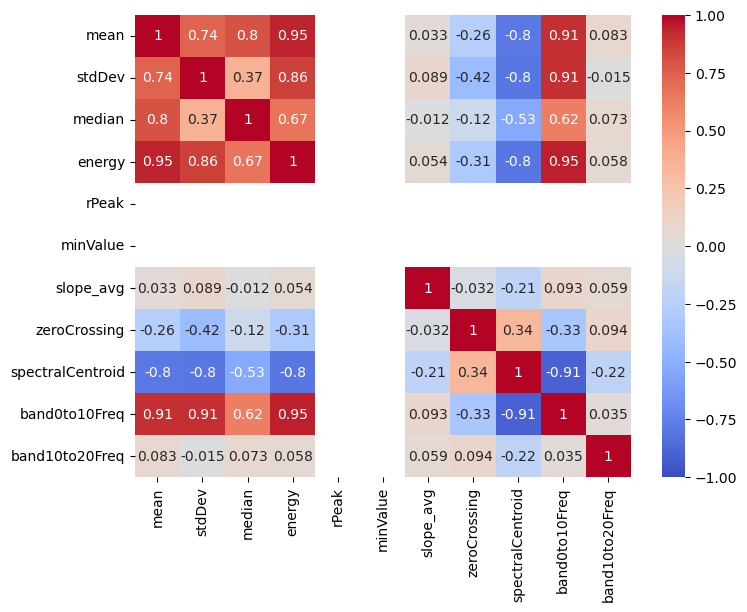

In [23]:
corr_matrix = feature_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.show()

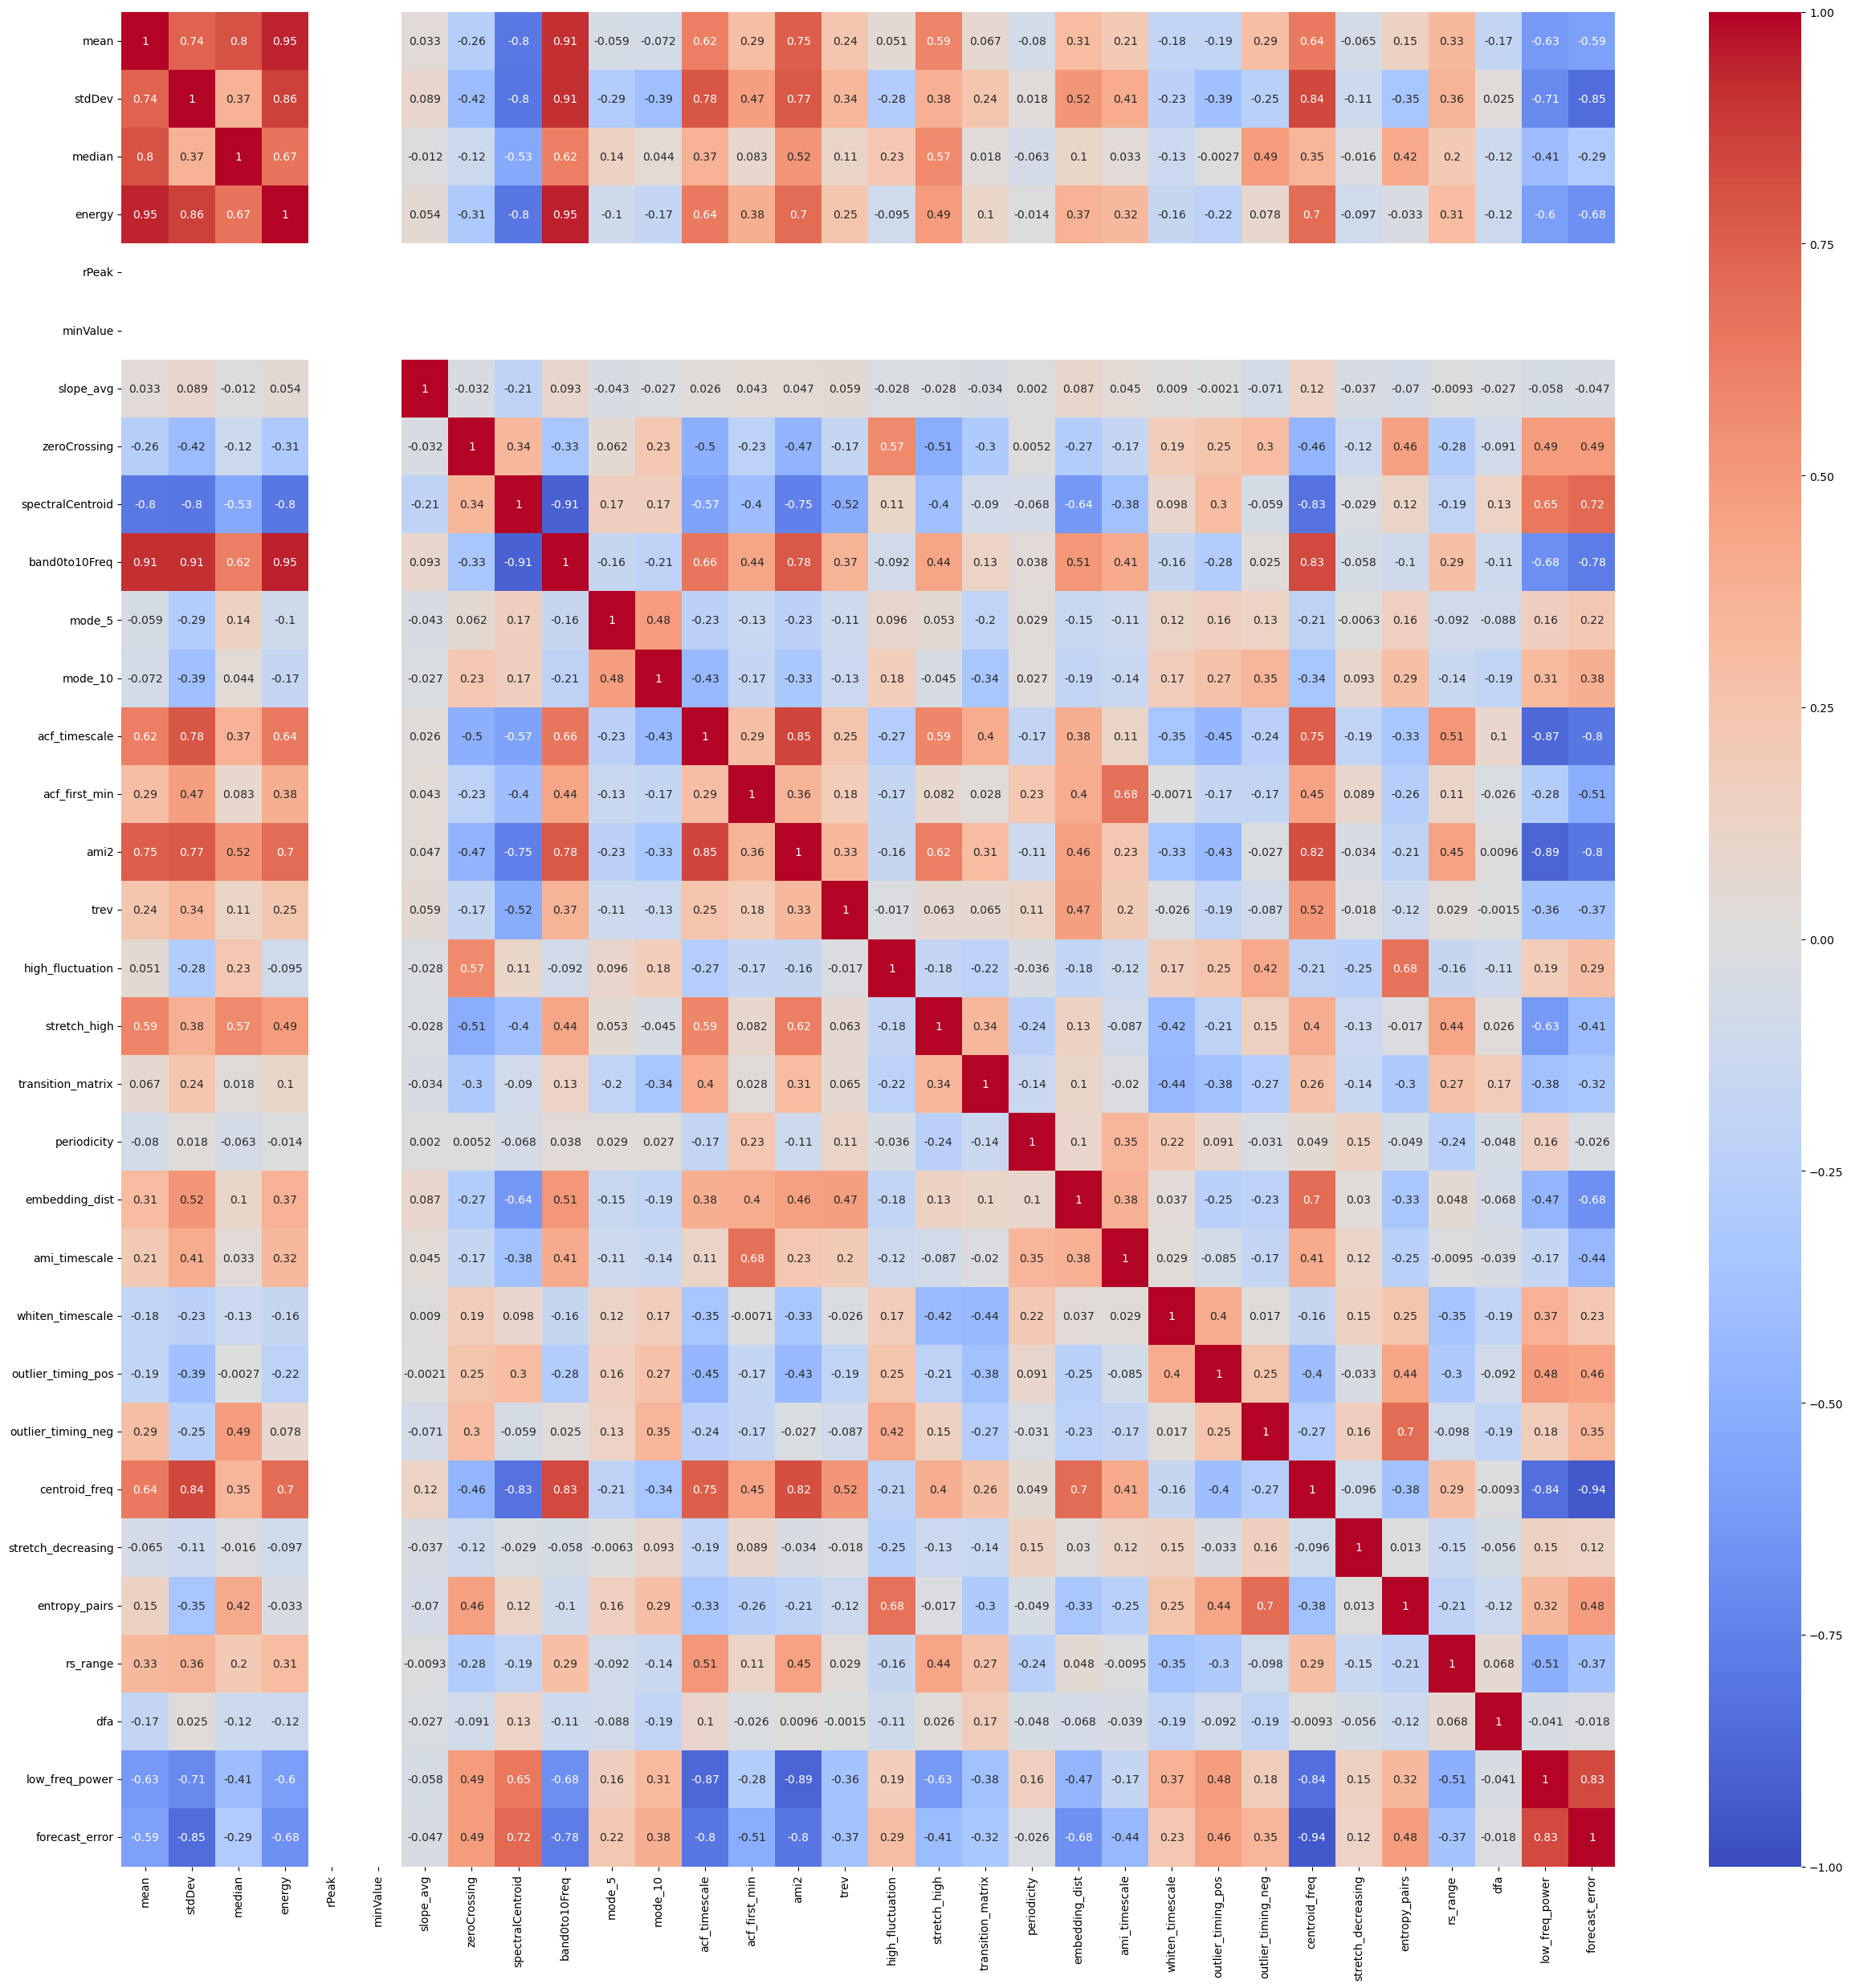

In [24]:
corr_matrix_catch22 = catch22_feature_df.corr()
plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix_catch22, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.show()

In [25]:
def get_high_correlation_features(
    corr_matrix: pd.DataFrame, p_value_greater_than: float = 0.7
) -> set[str]:
    """Identifies unique features with a correlation above a specified threshold.

    This function masks the upper triangle of the correlation matrix to avoid
    redundant pairs (A-B and B-A) and self-correlation (A-A), filters for
    high values, and extracts the unique feature names involved.

    Args:
        corr_matrix : pd.DataFrame
          A square pandas DataFrame representing the correlation matrix.
        p_value_greater_than : float
          The absolute p-value coefficient cutoff.

    Returns:
        A set of feature names that have at least one high-correlation connection.
    """
    # Create a mask for the upper triangle (not including the diagonal, this is the self correlation)
    # This prevents counting (A, B) and (B, A) as two different pairs and counting pairs like (A,A)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Apply mask, unstack to 1D pairs, and drop nans/lower triangle of correlation matrix
    unique_pairs = corr_matrix.mask(mask).unstack().dropna()

    # Filter for pairs with an absolute correlation higher than the threshold
    high_corr = unique_pairs[unique_pairs.abs() >= p_value_greater_than]

    # Extract unique feature names using set union of both index levels
    unique_names = set(high_corr.index.get_level_values(0)) | set(
        high_corr.index.get_level_values(1)
    )

    # Print statements for verification
    print(high_corr.sort_values(ascending=False))
    print("The number of features you want is: ", len(unique_names))
    print(unique_names)

    return unique_names

In [26]:
top_corr_features = get_high_correlation_features(
    corr_matrix=corr_matrix_catch22, p_value_greater_than=0.7
)

energy            band0to10Freq       0.951159
mean              energy              0.945010
stdDev            band0to10Freq       0.910075
mean              band0to10Freq       0.907297
stdDev            energy              0.864724
acf_timescale     ami2                0.850730
stdDev            centroid_freq       0.842427
low_freq_power    forecast_error      0.831833
band0to10Freq     centroid_freq       0.830476
ami2              centroid_freq       0.815999
mean              median              0.800345
stdDev            acf_timescale       0.782136
band0to10Freq     ami2                0.780783
stdDev            ami2                0.773852
acf_timescale     centroid_freq       0.751390
mean              ami2                0.750494
                  stdDev              0.738809
spectralCentroid  forecast_error      0.716244
stdDev            low_freq_power     -0.705396
spectralCentroid  ami2               -0.754120
band0to10Freq     forecast_error     -0.776237
mean         

In [27]:
def best_feature_with_RFE(
    X: pd.DataFrame,
    y: pd.Series,
    n_features_to_select: int,
    test_size: float = 0.2,
    random_state: int = 42,
) -> list:
    """Selects the most impactful features from a dataset using Recursive Feature Elimination (RFE)
    with a Random Forest Classifier.

    This function performs a train-test split, scales the feature data using StandardScaler,
    and applies RFE to iteratively remove the least important features until the specified
    number of features is reached.

    Args:
      X : pd.DataFrame
        A DataFrame containing all the features extracted from a 2D array of signals.
      y : pd.Series
        The classification of the signals.
      n_features_to_select : int
        The top total number of features to select.
      test_size : float
        The proportion of the dataset to include in the test split.
        Defaults to 20%(input value is equivalent to 0.2).
      random_state : int
        gives randomness to RFE.


    Returns:
      A list of strings containing the names of the selected feature columns.
    """
    # Training split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    print(f"X_Train features shape: {X_train.shape}")
    print(f"Y_Train target shape: {y_train.shape}")
    print(f"X_Test feature shape: {X_test.shape}")
    print(f"Y_Test target shape: {y_test.shape}")
    # Scale so no feature has more importance
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    # Initialize Random Forest
    # NOTE(shenuk) Dec 29, 2025: Need to explain n_estimators
    rfc_model = RandomForestClassifier(
        n_estimators=11, random_state=random_state, n_jobs=-1
    )

    # Initialize RFE to select the top N features
    rfe_rfc = RFE(estimator=rfc_model, n_features_to_select=n_features_to_select)
    rfe_rfc.fit(X_train_scaled, y_train)

    # Printing the extracted results to verify them
    print(f"\nFeature mask: {rfe_rfc.support_}")

    # Use the boolean mask (support_) to filter the column names
    selected_features = X_train.columns[rfe_rfc.support_].tolist()

    print(f"Selected Features: {selected_features}")

    return selected_features

In [28]:
selected_features = best_feature_with_RFE(
    X=catch22_feature_df,
    y=y,
    n_features_to_select=len(top_corr_features),
    random_state=RANDOM_SEED,
)

X_Train features shape: (11641, 32)
Y_Train target shape: (11641,)
X_Test feature shape: (2911, 32)
Y_Test target shape: (2911,)

Feature mask: [ True False False False False False False False False  True False False
  True  True False  True  True False False False  True False False False
  True  True  True False False False False  True]
Selected Features: ['mean', 'band0to10Freq', 'acf_timescale', 'acf_first_min', 'trev', 'high_fluctuation', 'embedding_dist', 'outlier_timing_neg', 'centroid_freq', 'stretch_decreasing', 'forecast_error']


### RFC Conclusion
- We found that ` ['mean', 'band0to10Freq', 'acf_timescale', 'acf_first_min', 'trev', 'high_fluctuation', 'embedding_dist', 'outlier_timing_neg', 'centroid_freq', 'stretch_decreasing', 'forecast_error']` where the best features after running RFC using RFE. Therefore, those feature will be used only in the decision tree.



In [38]:
def model_pipeline(
    X: pd.DataFrame,
    y: pd.Series,
    model: any,
    selected_features: list | None,
    random_seed: int = 42,
) -> None:
    """Trains a machine learning model and evaluates its performance through metrics and visualization.

    This function filters the dataset for selected features, performs a train-test split,
    scales the data, and then fits the provided model. It outputs a classification report
    and displays a confusion matrix heatmap.

    Args:
      X : pd.DataFrame
        A DataFrame containing all the features extracted from a 2D array of signals.
      y : pd.Series
        The classification of the signals.
      model : Any
        A machine learning model object (e.g., RandomForestClassifier, SVM, etc.).
      selected_features : Optional[List[str]]
        A list of specific feature column names to use for training. Defaults to None.
      random_seed : int
        random number used for reproducibility in the data split.


    Returns:
      None
    """
    # Filter features if a list is provided
    if selected_features is not None:
        X = X[selected_features]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_seed
    )

    print(f"X_Train features shape: {X_train.shape}")
    print(f"Y_Train target shape: {y_train.shape}")
    print(f"X_Test feature shape: {X_test.shape}")
    print(f"Y_Test target shape: {y_test.shape}")

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Predicting
    model.fit(X_train_scaled, y_train)
    model_pred_y = model.predict(X_test_scaled)

    print("\nClassification Report:")
    print(classification_report(y_true=y_test, y_pred=model_pred_y))
    print("#" * 70)

    # Visualization
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true=y_test, y_pred=model_pred_y)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Score")
    plt.ylabel("Actual Score")
    plt.title(f"Confusion Matrix: {type(model).__name__}")
    plt.show()

### Random Forest Training

X_Train features shape: (11641, 11)
Y_Train target shape: (11641,)
X_Test feature shape: (2911, 11)
Y_Test target shape: (2911,)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.90      0.93       834
         1.0       0.96      0.98      0.97      2077

    accuracy                           0.96      2911
   macro avg       0.96      0.94      0.95      2911
weighted avg       0.96      0.96      0.96      2911

######################################################################


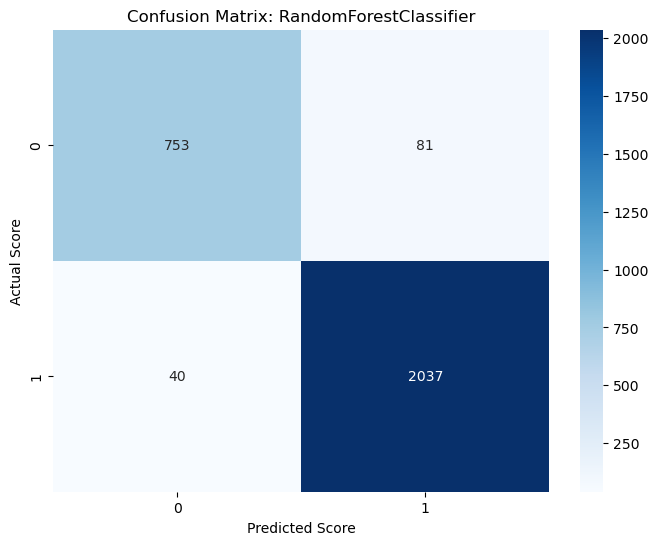

In [40]:
rfc_model = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1)
model_pipeline(X=catch22_feature_df, y=y,model=rfc_model,selected_features=selected_features)

### Decision Tree Training

X_Train features shape: (11641, 11)
Y_Train target shape: (11641,)
X_Test feature shape: (2911, 11)
Y_Test target shape: (2911,)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.67      0.75       834
         1.0       0.88      0.95      0.91      2077

    accuracy                           0.87      2911
   macro avg       0.86      0.81      0.83      2911
weighted avg       0.87      0.87      0.86      2911

######################################################################


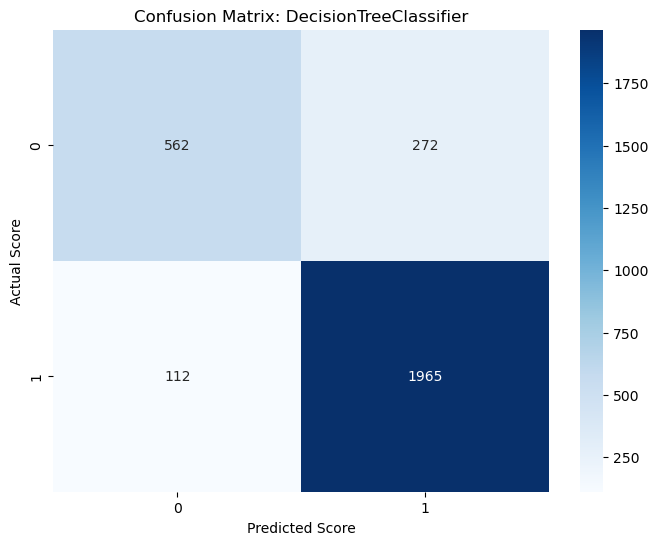

In [39]:
clf = DecisionTreeClassifier(criterion="entropy", max_depth=5, random_state=42)
model_pipeline(X=catch22_feature_df, y=y,model=clf,selected_features=selected_features)

              precision    recall  f1-score   support

         0.0       0.83      0.67      0.75       834
         1.0       0.88      0.95      0.91      2077

    accuracy                           0.87      2911
   macro avg       0.86      0.81      0.83      2911
weighted avg       0.87      0.87      0.86      2911

######################################################################


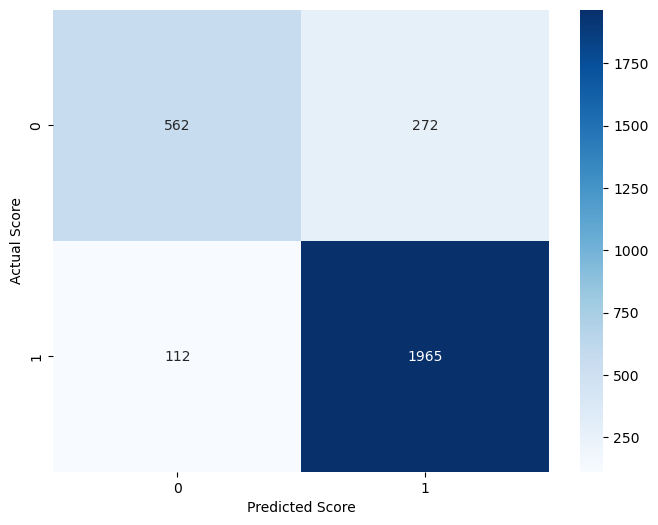